In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 87.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import pandas as pd
import io
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Responsible AI - Team #9 Folder/Data/(old) preprocessed_data.csv')
df.head()

,text,label
0,"This is so cool. It's like, 'would you want yo...",0
1,Thank you!! This would make my life a lot less...,0
2,This is such an urgent design problem; kudos t...,0
3,Is this something I'll be able to install on m...,0
4,haha you guys are a bunch of losers.,1


In [ ]:
drop_percentage = 0.993

category = 0
category_df = df[df['label'] == category]

num_rows_to_drop = int(drop_percentage * len(category_df))

remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

df = pd.concat([df[df['label'] != category], remaining_rows])

In [ ]:
drop_percentage = 0.92

category = 1
category_df = df[df['label'] == category]

num_rows_to_drop = int(drop_percentage * len(category_df))

remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

df = pd.concat([df[df['label'] != category], remaining_rows])

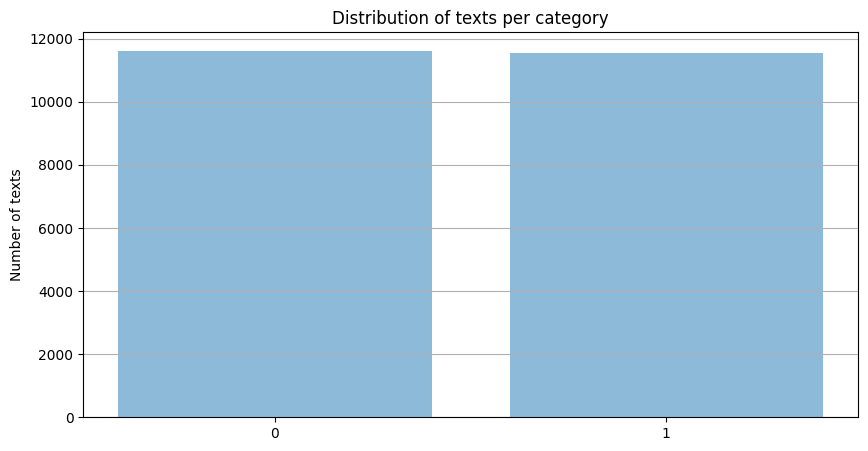

Counter({0: 11624, 1: 11547})


In [ ]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
df.sample(10)

,text,label
682220,Quebec cops are so crooked they screw their so...,0
1519379,Game out what will happen if Trump backs out o...,1
193327,No you are not correct. Look up Oracle and rea...,1
722204,wow. so much racism so quickly. Do you troll ...,1
431193,"I say ""chowder is just fine for the arrogant s...",1
690486,Levesque was not a democrat since he rigged th...,1
1674538,"The North Korea thing with their “missile”, do...",1
777019,Let's go with your rabbit analogy Steve.\n\nPe...,0
718550,This is enough reason to kick the LIEberals ou...,0
22012,"Eddie, you are completely wrong. It sounds lik...",1


In [ ]:
comments = df.text.values

comments = ["[CLS] " + comment + " [SEP]" for comment in comments]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(comment) for comment in comments]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2529877.18B/s]


Tokenize the first sentence:
['[CLS]', '.', 'the', 'next', 'time', 'you', 'buy', 'a', 'car', ',', 'all', 'things', 'being', 'equal', ',', 'do', 'yourself', ',', 'your', 'children', ',', 'your', 'community', 'and', 'your', 'country', 'a', 'positive', 'thing', 'and', 'consider', 'buying', 'a', 'model', 'from', 'one', 'of', 'the', 'companies', 'that', 'build', 'vehicles', 'in', 'your', 'country', '.', 'honda', ',', 'gm', ',', 'ford', ',', 'chrysler', ',', 'toyota', ',', 'all', 'build', 'cars', 'in', 'canada', ',', 'contributing', 'to', 'our', 'economy', 'and', 'keeping', 'large', 'amounts', 'of', 'canadian', 'wealth', ',', 'in', 'canada', 'when', 'someone', 'buys', 'a', 'bmw', ',', 'sub', '##aru', ',', 'hyundai', '/', 'kia', ',', 'mercedes', ',', 'volvo', ',', 'mazda', ',', 'nissan', ',', 'audi', '/', 'porsche', ',', 'v', '##w', ',', 'jaguar', ',', 'land', 'rover', ',', 'you', 'are', 'sending', 'most', 'of', 'the', 'purchase', 'price', 'of', 'the', 'vehicle', 'out', 'of', 'canada', ',', '

In [ ]:
MAX_LEN = 128

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs).to('cuda')
validation_inputs = torch.tensor(validation_inputs).to('cuda')
train_labels = torch.tensor(train_labels).to('cuda')
validation_labels = torch.tensor(validation_labels).to('cuda')
train_masks = torch.tensor(train_masks).to('cuda')
validation_masks = torch.tensor(validation_masks).to('cuda')

In [ ]:
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:07<00:00, 53351795.08B/s]


In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [ ]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import tqdm

t = [] 
train_loss_set = []
epochs = 10
device = 'cuda'
model.to(device)

for epoch in range(epochs):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  for step, batch in tqdm.tqdm(enumerate(train_dataloader)):
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  
  print("Epoch {}:".format(epoch+1))
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
326it [08:05,  1.49s/it]


Epoch 1:
Train loss: 0.3511848389828132
Validation Accuracy: 0.8899613899613901


326it [08:05,  1.49s/it]


Epoch 2:
Train loss: 0.19711496887808563
Validation Accuracy: 0.8614261583011583


326it [08:05,  1.49s/it]


Epoch 3:
Train loss: 0.1113901326512815
Validation Accuracy: 0.8696307915057915


326it [08:05,  1.49s/it]


Epoch 4:
Train loss: 0.05552256786824415
Validation Accuracy: 0.8637789575289575


326it [08:05,  1.49s/it]


Epoch 5:
Train loss: 0.029869403897219
Validation Accuracy: 0.8726472007722008


326it [08:05,  1.49s/it]


Epoch 6:
Train loss: 0.017273822707103342
Validation Accuracy: 0.8810931467181468


326it [08:05,  1.49s/it]


Epoch 7:
Train loss: 0.011387248769085754
Validation Accuracy: 0.871138996138996


326it [08:06,  1.49s/it]


Epoch 8:
Train loss: 0.010470153028125791
Validation Accuracy: 0.8783783783783784


326it [08:05,  1.49s/it]


Epoch 9:
Train loss: 0.01039796296707633
Validation Accuracy: 0.875603281853282


326it [08:05,  1.49s/it]


Epoch 10:
Train loss: 0.007458179777951809
Validation Accuracy: 0.8772924710424711


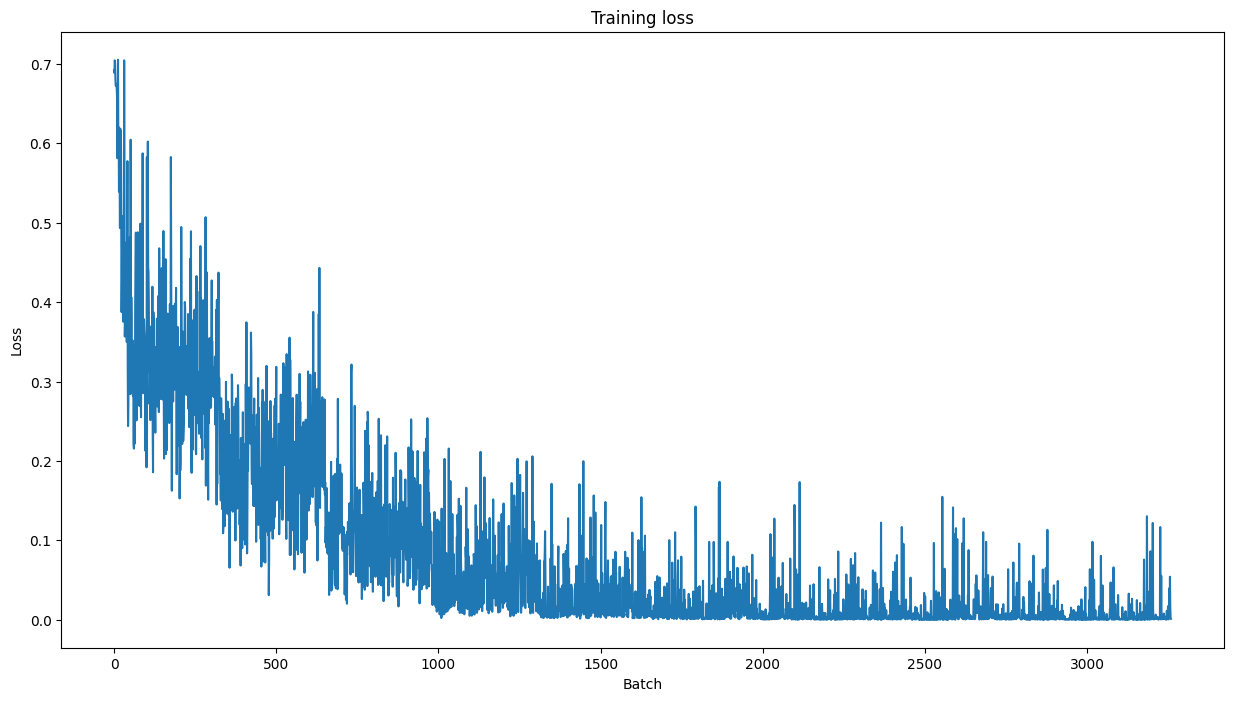

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Responsible AI - Team #9 Folder/Trained Model/BERT_pretrained.pth')

In [ ]:
# Saving the data on which the model was trained (complete dataset was not used)

import csv

data = list(zip(comments, labels))

# Save the data to a CSV file
output_file = 'Original Data (Small).csv'
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Comments', 'Labels'])  # Write header row
    writer.writerows(data)